In [15]:
import pickle, os, numpy as np
from matplotlib import pyplot as plt

# Useful helper function for determining stdevs for correlated time-series data ie Covar(X_t, X_t+1) != 0

def block_average(values, num_blocks):
    N = values.shape[0]
    values = values[: (N // num_blocks) * num_blocks] # Cut off the last block as necessary
    blocks = values.reshape((num_blocks, N // num_blocks))
    block_avg = blocks.mean(axis = -1)
    return block_avg

# Part 1: Exhibit Energy Conservation Scaling with (dt^2)

- NVE system
- Identical initial conditions (r0, v0)
- All other params are the same
- Vary only dt between simulations

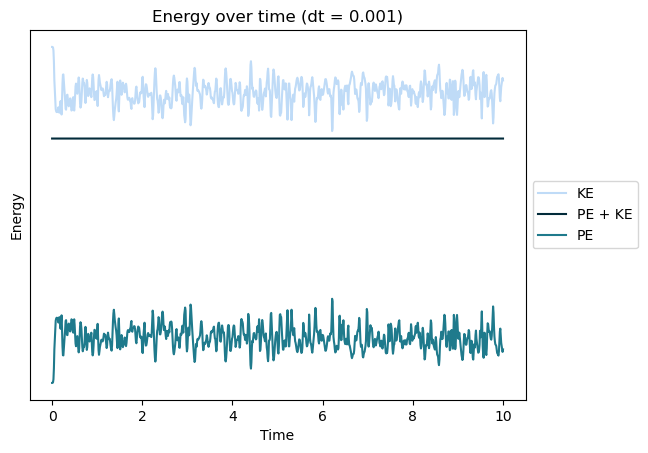

In [2]:
colors = ['#022b3a', '#1f7a8c', '#bfdbf7']

job_dir = f'./runs/time_screens/totaltime=10_dt=10e-4'

with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)
time = data['time']
system_energy = data['system_energy']
system_pe = data['system_pe']
system_ke = data['system_ke']

plt.plot(time, system_ke, label = 'KE', color = colors[2])
plt.plot(time, system_energy, label = f'PE + KE', color = colors[0])
plt.plot(time, system_pe, label = 'PE', color = colors[1])

plt.title('Energy over time (dt = 0.001)')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.yticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('./ke_pe.png', bbox_inches='tight')
plt.show()

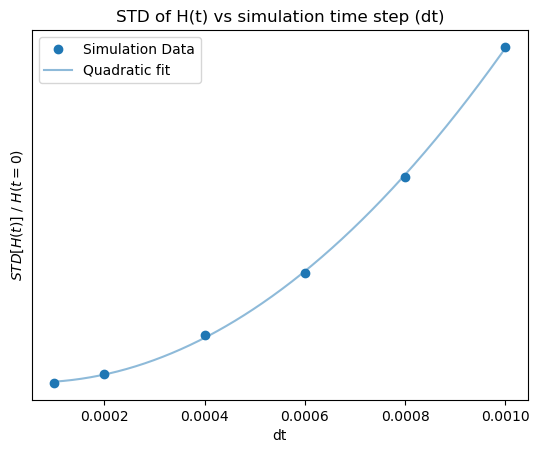

In [3]:
dH = []
dt_lst= np.array([0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])

for i, dt in enumerate(dt_lst):
    job_dir = f'./runs/time_screens/totaltime=10_dt={int(dt * 10_000)}e-4'

    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)
    time = data['time']
    system_energy = data['system_energy']
    dH.append(system_energy.std())

dH = np.array(dH)/dH[0]
plt.plot(dt_lst, dH, 'o', label='Simulation Data')
    
# Fit a quadratic polynomial: y = ax^2 + bx + c
coeffs = np.polyfit(dt_lst, dH, deg=2)
poly = np.poly1d(coeffs)

dt_fit = np.linspace(dt_lst.min(), dt_lst.max(), 500)
dH_fit = poly(dt_fit)

# Plot the quadratic fit
dH_pred = poly(dt)
plt.plot(dt_fit, dH_fit, '-', label=rf'Quadratic fit', color = 'tab:blue', alpha = 0.5)

plt.xlabel('dt')
plt.ylabel(r'$STD[H(t)]$ / $H(t=0)$')
plt.yticks([])
plt.legend()
#plt.savefig('./quadratic_fit.png')
plt.title(r'STD of H(t) vs simulation time step (dt)')
plt.show()

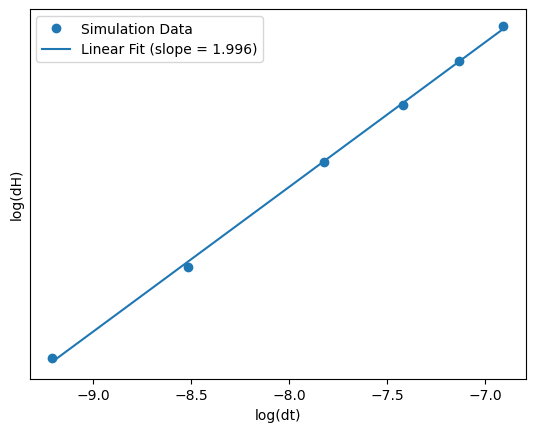

In [4]:
from scipy.stats import linregress

log_dH = np.log(dH)
log_dt = np.log(dt_lst)

plt.plot(log_dt, log_dH, 'o', label='Simulation Data')
slope, intercept, r_value, p_value, std_err = linregress(log_dt, log_dH)
fit_line = slope * log_dt + intercept
plt.plot(log_dt, fit_line, '-', label=f'Linear Fit (slope = {slope:.3f})', color = 'tab:blue')

plt.xlabel('log(dt)')
plt.ylabel('log(dH)')
plt.yticks([])
plt.legend()
plt.show()

# Part 2: Langevin Dynamics

All following plots are from simulations performed at constant temperature. As such, we want to exhibit that the thermostat works through the following plots:

1. Temperature over time - while temperature may fluctuate, the time average temperature should be equal to the target temperature.
2. Energy vs Time - this is mainly just to visualize energy fluctuations, not super super insightful for determining if temp is conserved
3. Maxwell Boltzmann Distribution for KE and for v_x - 

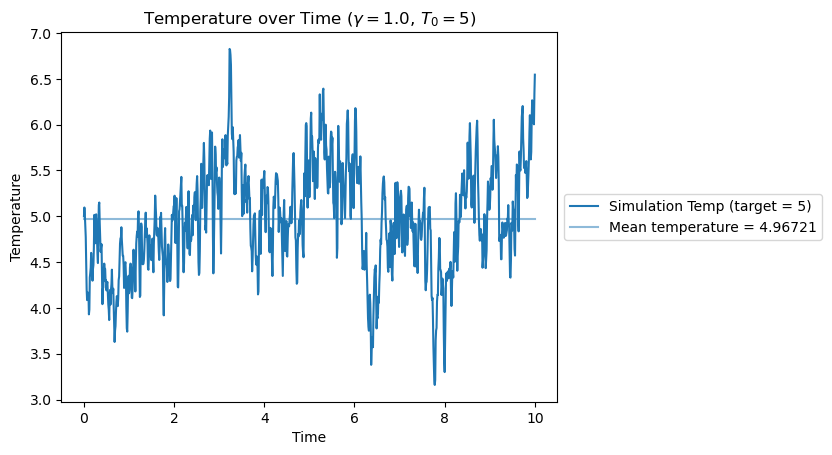

In [5]:
job_dir = f'./runs/gamma_screens/gamma={1.0}'
    
with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)

time = data['time']
temp = data['temp']

plt.plot(time, temp, label = 'Simulation Temp (target = 5)')
plt.plot(time, np.ones_like(time) * temp.mean(), label = f'Mean temperature = {temp.mean():.6g}', color = 'tab:blue', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Temperature over Time ($\gamma = 1.0$, $T_0 = 5$)')
plt.show()

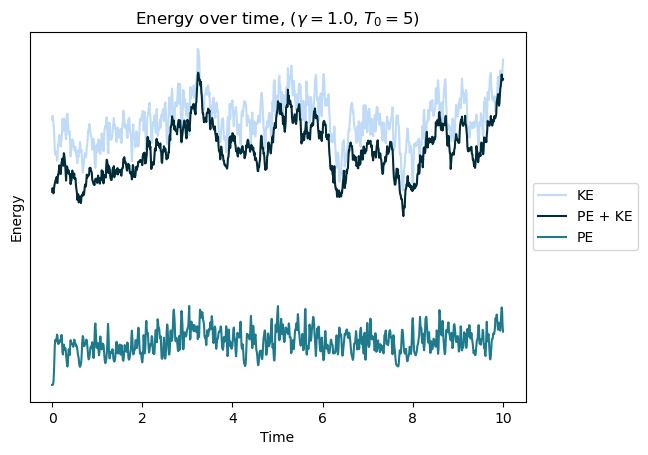

In [6]:
colors = ['#022b3a', '#1f7a8c', '#bfdbf7']

job_dir = f'./runs/gamma_screens/gamma={1.0}'
    
with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)
    
    
time = data['time']
system_energy = data['system_energy']
system_pe = data['system_pe']
system_ke = data['system_ke']

plt.plot(time, system_ke, label = 'KE', color = colors[2])
plt.plot(time, system_energy, label = f'PE + KE', color = colors[0])
plt.plot(time, system_pe, label = 'PE', color = colors[1])

plt.title('Energy over time, ($\gamma = 1.0$, $T_0 = 5$)')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.yticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('./ke_pe.png', bbox_inches='tight')
plt.show()

4.9672100929533896


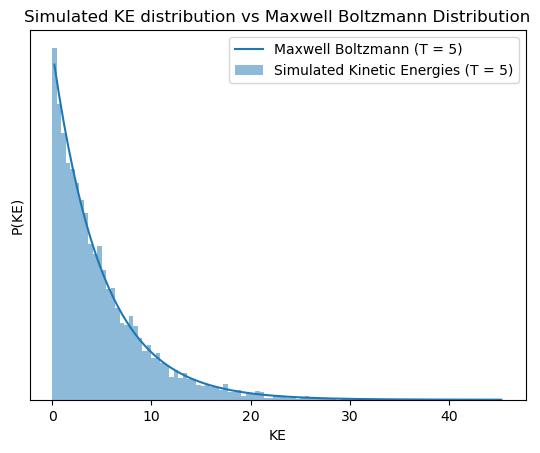

In [7]:
"""
Kinetic Energy distribution versus Maxwell Boltzmann Distribution
Samples are aggregated across 10 time points across T. This is because
N is not large enough to give a super nice distribution so we need multiple
independent time points to give a larger N. Time points are chosen uniformly
across (0, T) so that velocities are not correlated between time points
"""
from src.utils import bin_values, k_B

colors = ['#022b3a', '#1f7a8c', '#bfdbf7']

job_dir = f'./runs/gamma_screens/gamma={1.0}'
    
with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)

per_atom_ke = data['per_atom_ke'] #(T, N)
temp = data['temp']
T = per_atom_ke.shape[0]
print(temp.mean()) # Should be 5
temp = 5

time_points = np.arange(0, T, 10)
ke = per_atom_ke[time_points, :].flatten()
bin_centers, bin_heights = bin_values(ke, num_bins = 100)
bin_heights = bin_heights / bin_heights.sum()

plt.bar(bin_centers, bin_heights, width = bin_centers[1] - bin_centers[0],
        label = 'Simulated Kinetic Energies (T = 5)', alpha = 0.5)

maxwell_boltzmann_dist = np.exp(-bin_centers / k_B / temp)
maxwell_boltzmann_dist = maxwell_boltzmann_dist / maxwell_boltzmann_dist.sum()
plt.plot(bin_centers, maxwell_boltzmann_dist, label = 'Maxwell Boltzmann (T = 5)')

plt.ylabel('P(KE)')
plt.yticks([])
plt.xlabel('KE')
plt.title('Simulated KE distribution vs Maxwell Boltzmann Distribution')
plt.legend()

plt.show()

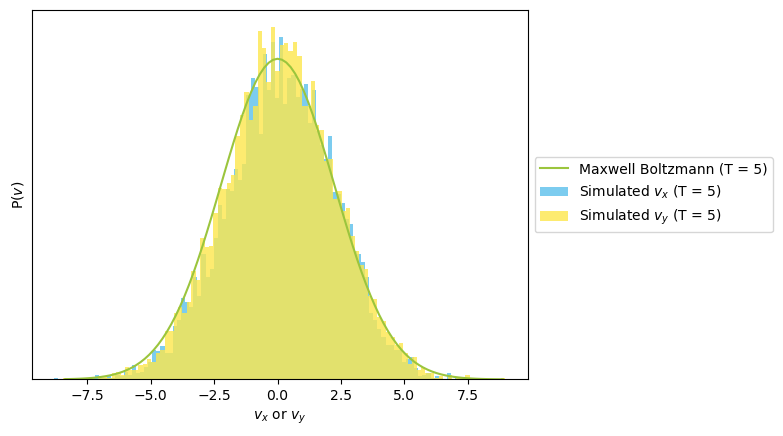

In [10]:
"""
Same plot as above. But this time, it plots velocity in one direction instead
of total velocity.

Velocity should follow a Gaussian if masses are all the same.
"""

from src.utils import bin_values, k_B

colors = ['#5bc0eb', '#fde74c', '#9bc53d']

job_dir = f'./runs/density_screens_eps=1/N=65'
    
with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)

temp = 5
v = data['v']
v_x = v[:, :, 0]
time_points = np.arange(0, v.shape[0], 10)
v_x = v_x[time_points, :].flatten() # (N * 10,)
bin_centers, bin_heights = bin_values(v_x, num_bins = 100)
bin_heights = bin_heights / bin_heights.sum()

plt.bar(bin_centers, bin_heights, width = bin_centers[1] - bin_centers[0],
        label = r'Simulated $v_x$ (T = 5)', color = colors[0], alpha = 0.8)

v_y = v[:, :, 1]
time_points = np.arange(0, v.shape[0], 10)
v_y = v_y[time_points, :].flatten() # (N * 10,)
v_y = v_y.flatten()
bin_centers, bin_heights = bin_values(v_y, num_bins = 100)
bin_heights = bin_heights / bin_heights.sum()

plt.bar(bin_centers, bin_heights, width = bin_centers[1] - bin_centers[0],
        label = r'Simulated $v_y$ (T = 5)', color = colors[1], alpha = 0.8)

ke_x = bin_centers ** 2 / 2 # mass = 1
maxwell_boltzmann_dist = np.exp(- ke_x / k_B / temp)
maxwell_boltzmann_dist = maxwell_boltzmann_dist / maxwell_boltzmann_dist.sum()
plt.plot(bin_centers, maxwell_boltzmann_dist, 
         label = 'Maxwell Boltzmann (T = 5)', color = colors[2])

plt.ylabel(r'P($v$)')
plt.yticks([])
plt.xlabel(r'$v_x$ or $v_y$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Part 3: Screening gamma

- NVT system
- Identical initial conditions (r0, v0)
- All other params are the same
- Vary only gamma between simulations

Some observations: 
- For low friction, the temperature is too low but it rises over time. Maybe the system needs more time to equilibrate since the random knocks are extremely small.
- At high friction, the temperature fluctuates similarly (see second and third plots) but the time scale of fluctuations is different (see first plot). For gamma = 100, the smoothed temperature curve seems much more stable but for gamma = 1.0, the smoothed temperature curve looks less stable. Though, this is might be more due to the smoothing of the curves. Plots 2 and 3 show that the actual standard deviations are comparable. 

TODO - read up on underdamped + overdamped systems

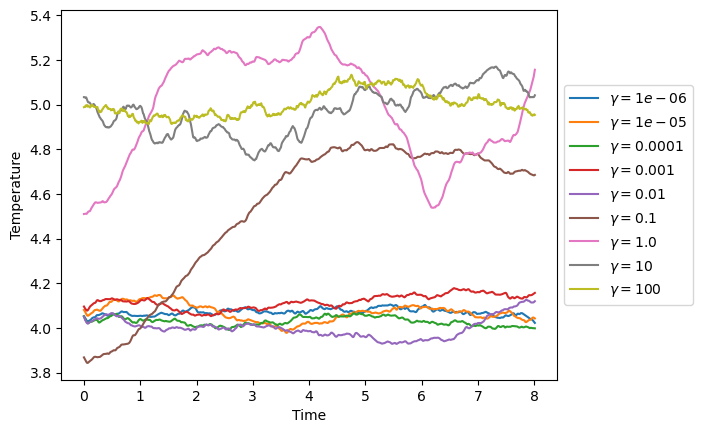

In [17]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


temp_means = []
temp_stds = []

gamma_lst = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
for i, gamma in enumerate(gamma_lst):
    job_dir = f'./runs/gamma_screens/gamma={gamma}'
    
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)

    time = data['time']
    temp = data['temp']
    temp_means.append(temp.mean())
    temp_stds.append(temp.std())
    smoothed_temp = moving_average(temp, w=200)  # w = window size
    smoothed_time = time[:len(smoothed_temp)]

    plt.plot(smoothed_time, smoothed_temp, label=rf'$\gamma = {gamma}$')    


plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Part 4: Gamma vs Diffusion Coefficient (WIP)

I found this plot on pg 355 for Diffusion constants vs gamma. Haven't fully recreated it yet. 

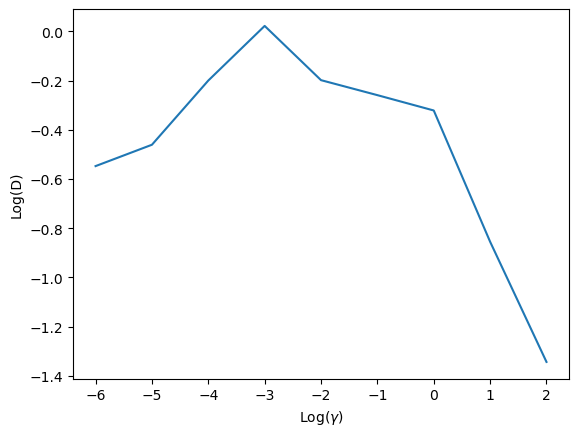

In [20]:
from src.utils import compute_diffusion_coeff_v

gamma_lst = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
D_lst = []
for i, gamma in enumerate(gamma_lst):
    job_dir = f'./runs/gamma_screens/gamma={gamma}'
    
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)

    time = data['time']
    v = data['v']
    D = compute_diffusion_coeff_v(v, time)
    D_lst.append(D)
    

plt.plot(np.log10(gamma_lst), np.log10(D_lst))    



plt.xlabel(r'Log($\gamma$)')
plt.ylabel('Log(D)')
plt.show()

# Part 5: Pressure vs Density

- NVT system
- Temperature is fixed (T = 5)
- N is varied across simulations. Since N varies, r0 and v0 are also randomized but are sampled from identical distributions
- All other parameters held constant
- It's worth noting that the unit cell is 10x10 and sigma = 1.0 so for N = 100, r0 is so that neighboring atoms are separated by sigma. 

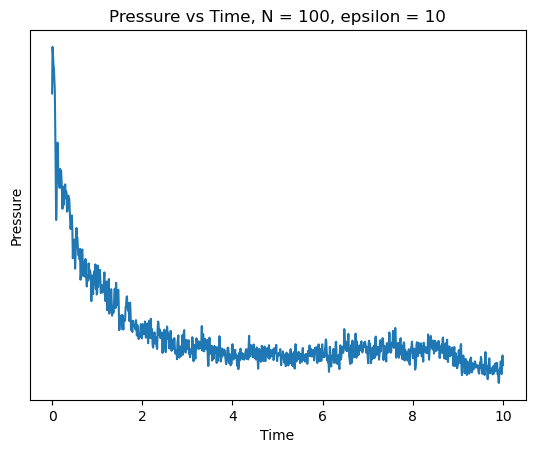

In [23]:
from src.utils import compute_pressure

job_dir = f'./runs/density_screens_eps=10/N=100'
with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)

masses = data['masses']

time = data['time']
r = data['r']
v = data['v']
potential = data['potential']
unit_cell = data['unit_cell']

p = np.array([compute_pressure(masses, r[t], v[t], potential, unit_cell) for t in range(len(r))])

plt.plot(time, p,)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.yticks([])
plt.title('Pressure vs Time, N = 100, epsilon = 10')
plt.show()

Based on the plot above, it looks like pressure stabilizes around T>5. For the plot below, pressures are computed for the equilibrated system.

1.066295897705772
1.6568733769099484
2.3262004462277295
2.8723410986432483
3.0832732735880333
4.094647511381693
5.209957929895221
6.449304519128852
6.976831735324739
9.065759113157466
11.159928693637102
14.710331617382465
17.44431128424268
22.284284913421665
28.859211408109616
36.68049083983838
46.64112045815384
0.45350477987604937
0.2499025801147842
0.2726081743145274
0.37440512131936876
0.23858862902465855
-0.3443642278735345
0.056618981074617845
-0.6661694212866236
-1.0926579004372743
-0.946907791669941
1.4836334610984452
3.8170477892341323
7.430078279175859
10.490852289602264
25.16479764166074
68.13949884447052
118.38806608608085


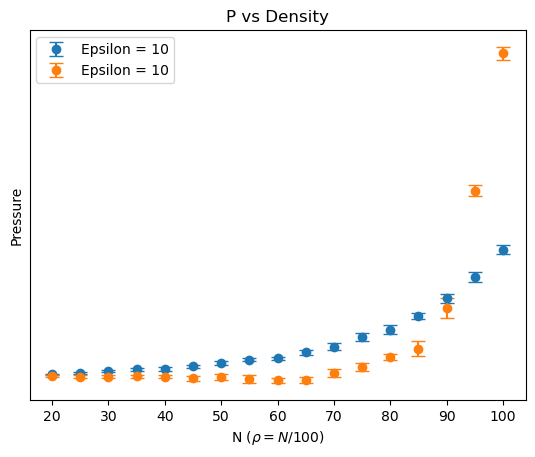

In [24]:
p_means_1 = []
p_stds_1 = []

Ns = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
for N in Ns:
    job_dir = f'./runs/density_screens_eps=1/N={N}'
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)

    masses = data['masses']
    r = data['r'][500:]
    v = data['v'][500:]
    potential = data['potential']
    unit_cell = data['unit_cell']

    p = np.array([compute_pressure(masses, r[t], v[t], potential, unit_cell) for t in range(r.shape[0])])
    p_blocks = block_average(p, 10)
    
    print(p_blocks.mean())
    p_means_1.append(p_blocks.mean())
    p_stds_1.append(p_blocks.std())

plt.errorbar(Ns, p_means_1, yerr = p_stds_1, fmt = 'o', capsize = 5, label = 'Epsilon = 10')

p_means_10 = []
p_stds_10 = []

Ns = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
for N in Ns:
    job_dir = f'./runs/density_screens_eps=10/N={N}'
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)

    masses = data['masses']
    r = data['r'][500:]
    v = data['v'][500:]
    potential = data['potential']
    unit_cell = data['unit_cell']

    p = np.array([compute_pressure(masses, r[t], v[t], potential, unit_cell) for t in range(r.shape[0])])
    p_blocks = block_average(p, 10)
    
    print(p_blocks.mean())
    p_means_10.append(p_blocks.mean())
    p_stds_10.append(p_blocks.std())

plt.errorbar(Ns, p_means_10, yerr = p_stds_10, fmt = 'o', capsize = 5, label = 'Epsilon = 10')
plt.ylabel('Pressure')
plt.yticks([])
plt.xlabel(r'N ($\rho = N / 100$)')
plt.title(r'P vs Density')
plt.legend()
plt.show()

When density becomes excessively large, the pressure also shoots up. At that limit, most particles are likely within the repulsive regime of neighboring particles' potentials so there is an immense amount of force applied between particles, which contributes to the $r \dot F$ term in the pressure equation. Temperature is held constant so contributions to the KE term should be negligible. 


In the low density regime, it looks like pressure is pretty constant wrt density. There's a pretty anomolous jump in behavior from N = 64 to N = 81. I'm not sure what that is

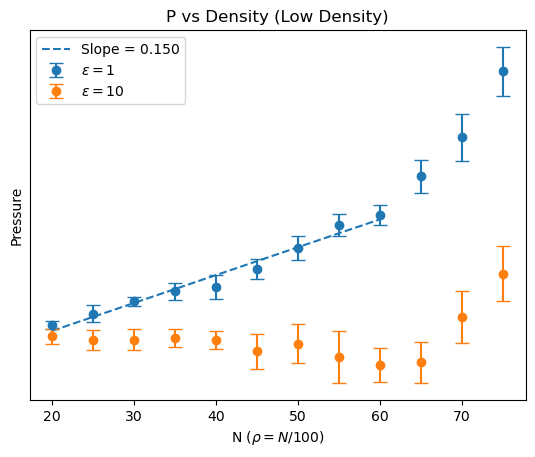

In [39]:
coeffs = np.polyfit(Ns[:9], p_means_1[:9], deg=1)  # coeffs[0] = slope, coeffs[1] = intercept
fit_fn = np.poly1d(coeffs)

# Plot error bars
plt.errorbar(Ns[:12], p_means_1[:12], yerr=p_stds_1[:12], fmt='o', capsize=5, label=f'$\epsilon = 1$')

# Plot line of best fit
x_fit = np.linspace(Ns[0], Ns[8], 100)
plt.plot(x_fit, fit_fn(x_fit), '--', label=f'Slope = {coeffs[0]:.3f}', color = 'tab:blue')


plt.errorbar(Ns[:12], p_means_10[:12], yerr=p_stds_10[:12], fmt='o', capsize=5, label=f'$\epsilon = 10$')

# Labels and formatting
plt.ylabel('Pressure')
plt.yticks([])
plt.xlabel(r'N ($\rho = N / 100$)')
plt.title(r'P vs Density (Low Density)')
plt.legend()
plt.show()

# Part 6: Radial Density Function vs Density

These plots are generated using the same data as Part 4. 

We're able to get data that oscillates in the high density regime and looks like an inverse Lennard Jones for the low density regime!

348.51615570730615
672.9916841505158
941.0534353800639
1854.7831388488387


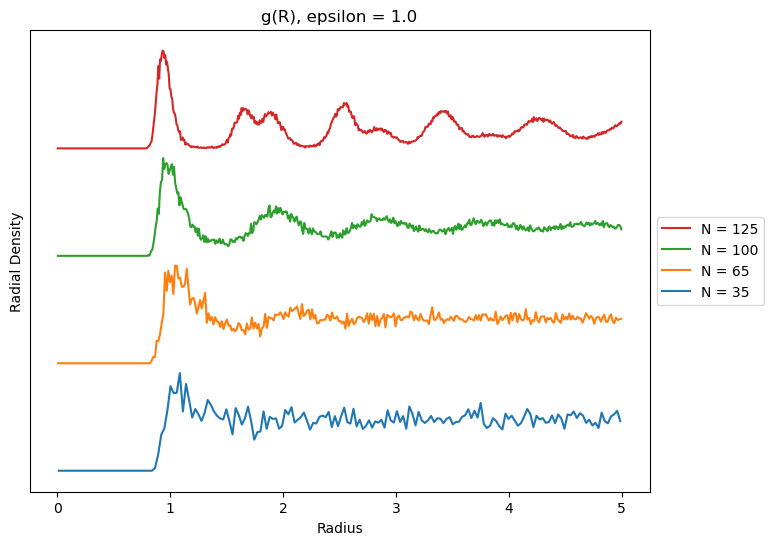

In [40]:
from src.utils import normalized_radial_density_function

#fig, axes = plt.subplots(4, 1, figsize=(6, 8))  
#x_low = np.inf
#x_high = -np.inf
plt.figure(figsize=(8, 6))

offset = 0
for i, N in enumerate([35, 65, 100, 125]):
    #ax = axes[i]
    job_dir = f'./runs/density_screens_eps=1/N={N}'
    with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
        data = pickle.load(f)
    r = data['r'][600::20] # Start at t = 600, go until the end, only consider every 20 to decorrelate a little
    unit_cell = data['unit_cell']
    bin_centers, bin_heights = normalized_radial_density_function(r, unit_cell, num_bins= int(750 / 144 * N), bin_lims = [0, 5])
    print(bin_heights[-1])
    bin_heights = bin_heights / bin_heights.max()
    
    plt.plot(bin_centers, bin_heights + i * 1.10, label = f'N = {N}')
    

plt.xlabel("Radius")
plt.ylabel("Radial Density")
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("g(R), epsilon = 1.0")
plt.show()

In [ ]:
job_dir = f'./runs/density_screens/N={N}'
with open(os.path.join(job_dir, 'data.pkl'), 'rb') as f:
    data = pickle.load(f)
r = data['r'][800:1000] # Chooose 100 times points after the system is well equilibrated
unit_cell = data['unit_cell']
bin_centers, bin_heights = normalized_radial_density_function(r, unit_cell, num_bins=100)

plt.plot(bin_centers, bin_heights)
plt.title(r'$N = 144$    $\sigma = 1.0$')
plt.ylabel('Radial Density')
plt.yticks()
plt.xlabel('Radius')
plt.show()